# Compare self-trained models

## Compare models on training dataset

In [1]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1" # suppresses Huggingface warning of storing data rather than symlinking it
from transformers import AutoTokenizer, AutoModelForPreTraining, pipeline

import sys
sys.path.append('../../')
# load functions for import of clinicaltrials.gov data written previously
from app.data.loader import load_trials_json, extract_from_clinicaltrials
from app.nlp.pipelines import load_ner_trained_pipeline
from app.nlp.utils import * # custom functions required for NER and summarization
from app.nlp.evaluate_model import elements_from_cell, substring_partial_overlap, evaluate_ner_model_partial_overlap, measure_processing_time, calculate_batch_throughput
from rouge_score import rouge_scorer # library for ROUGE score calculation

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# data extracted during training on colab, listed are metrics on test dataset
train_results_cb = {'model':'compact-biobert','training_time':1778.84,'inference_time': 23.86, 'eval_loss': 0.005029556341469288, 'eval_precision': 0.9908081194944466, 'eval_recall': 0.9919478527607362, 'eval_f1': 0.9913776585552788, 'eval_runtime': 23.8608, 'eval_samples_per_second': 64.835, 'eval_steps_per_second': 8.131, 'epoch': 3.0}
train_results_mb = {'model':'bio-mobilebert','training_time':1638.39,'inference_time': 23.34, 'eval_loss': 0.004630366340279579, 'eval_precision': 0.9858454475899006, 'eval_recall': 0.9881134969325154, 'eval_f1': 0.9869781692837993, 'eval_runtime': 23.3364, 'eval_samples_per_second': 66.291, 'eval_steps_per_second': 8.313, 'epoch': 3.0}
train_results_bb = {'model':'biobert-v1.1','training_time':3492.89,'inference_time': 44.67, 'eval_loss': 0.002541647059842944, 'eval_precision': 0.9961715160796325, 'eval_recall': 0.9976993865030674, 'eval_f1': 0.9969348659003832, 'eval_runtime': 44.6654, 'eval_samples_per_second': 34.635, 'eval_steps_per_second': 4.343, 'epoch': 3.0}


# Create a DataFrame
df_traing = pd.DataFrame([train_results_cb, train_results_mb, train_results_bb])

# Display the DataFrame
print(df_traing)


             model  training_time  inference_time  eval_loss  eval_precision  \
0  compact-biobert        1778.84           23.86   0.005030        0.990808   
1   bio-mobilebert        1638.39           23.34   0.004630        0.985845   
2     biobert-v1.1        3492.89           44.67   0.002542        0.996172   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0     0.991948  0.991378       23.8608                   64.835   
1     0.988113  0.986978       23.3364                   66.291   
2     0.997699  0.996935       44.6654                   34.635   

   eval_steps_per_second  epoch  
0                  8.131    3.0  
1                  8.313    3.0  
2                  4.343    3.0  


## Compare models on GOLD dataset

In [3]:
PROJECT_ROOT = os.path.expanduser('~/Documents/github/biomed_extractor')

ner_pipeline_hf = pipeline(
    "token-classification",
    model="kamalkraj/BioELECTRA-PICO",
    aggregation_strategy="simple"
)

model_dirs = [
    os.path.join(PROJECT_ROOT, 'app/model/nlpie_compact_biobert_PICO'),
    os.path.join(PROJECT_ROOT, 'app/model/nlpie_bio-mobilebert_PICO'),
    os.path.join(PROJECT_ROOT, 'app/model/dmis-lab_biobert-v1.1')
]

ner_pipelines = [
    load_ner_trained_pipeline(model_dir=dir_path)
    for dir_path in model_dirs
]


Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


In [4]:
# load gold standard trials
# Load and process data from clinicaltrials.gov
PROJECT_ROOT = os.path.expanduser('~/Documents/github/biomed_extractor')

# Data directory at top level
DATA_DIR = os.path.join(PROJECT_ROOT, 'data\\annotated')

df_json = load_trials_json(filepath = DATA_DIR, filename ='study_details_supergoldseet.json')
#print(df_json.head())
mydf_manual_annotation = extract_from_clinicaltrials(df_json)
mydf_manual_annotation.head()

Loaded 195 records from study_details_supergoldseet.json


,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name
0,NCT02263885,"The proposed study will evaluate the safety, a...",The purpose of this study is to evaluate the s...,"men and women, age 30 years and older; subject...",presence of other central neurodegenerative di...,ExAblate Transcranial System,Adverse Events
1,NCT02337725,The purpose of this study is to evaluate the e...,"This is a multicenter, randomized, double-blin...",run-in period; in the opinion of the investiga...,run-in period; the participant has received an...,TVP-1012; Placebo,Change From Baseline in Movement Disorder Soci...
2,NCT02337738,The purpose of this study is to evaluate the e...,"This is a multicenter, randomized, double-blin...",in the opinion of the investigator or sub-inve...,the participant has received any investigation...,TVP-1012; TVP-1012 0.; Placebo,Change From Baseline in Mean Daily OFF-time Du...
3,NCT02337751,The purpose of this study is to evaluate the l...,"This is a multicenter, open-label, long-term, ...",the participant has completed the preceding st...,the participant has undergone blood collection...,TVP-1012,Number of Participants Who Experience at Least...
4,NCT02337764,The purpose of this study is to evaluate long-...,"This is a multicenter, open-label, long-term, ...",in the opinion of the investigator or sub-inve...,,TVP-1012,Number of Participants Who Experience at Least...


In [5]:
# Process all NER pipelines on the gold dataset and store results in a list
ner_results = []

# Process custom models
for ner_pipeline in ner_pipelines:
    ner_res_model = process_trials_for_retrained_PICO(mydf_manual_annotation, ner_pipeline)
    ner_res_model.sort_values(by=['nctId'], inplace=True)
    ner_res_model.rename(columns={
        'population_extracted': 'population',
        'intervention_extracted': 'intervention',
        'comparator_extracted': 'comparator',
        'outcome_extracted': 'outcome',
        'summary_extracted': 'summary'
    }, inplace=True)
    # Only append, do not merge or concat
    ner_results.append(ner_res_model[['nctId', 'population', 'intervention', 'comparator', 'outcome', 'summary']].copy())

# Huggingface pipeline
ner_res_model_hf = process_trials_for_PICO(mydf_manual_annotation, ner_pipeline_hf)
ner_res_model_hf.sort_values(by=['nctId'], inplace=True)
ner_res_model_hf.rename(columns={
    'population_extracted': 'population',
    'intervention_extracted': 'intervention',
    'comparator_extracted': 'comparator',
    'outcome_extracted': 'outcome',
    'summary_extracted': 'summary'
}, inplace=True)
ner_results = [ner_res_model_hf[['nctId', 'population', 'intervention', 'comparator', 'outcome', 'summary']].copy()] + ner_results

model_names = ["BioELECTRA-PICO", "nlpie_compact_biobert_PICO", "nlpie_bio-mobilebert_PICO", "dmis-lab_biobert-v1.1"]
ner_results_dict = dict(zip(model_names, ner_results))

# Peek into results
for name, df in ner_results_dict.items():
    print(f"{name} predictions:")
    print(df.head())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


BioELECTRA-PICO predictions:
         nctId                                         population  \
0  NCT02263885  disabling motor complications of pd on optimum...   
1  NCT02337725  iii total score of \ > = 14 at the start of th...   
2  NCT02337738  drug for \ > = 6 months prior to the start of ...   
3  NCT02337751                                                      
4  NCT02337764  a history of syncope due to hypotension within...   

                 intervention comparator              outcome  \
0       exablate transcranial                          safety   
1                 of tvp 1012    placebo  efficacy and safety   
2  1 mg of tvp 1012; levodopa    placebo  efficacy and safety   
3                    tvp 1012                                   
4          levodopa; tvp 1012                                   

                                             summary  
0  The proposed study will evaluate the safety, a...  
1  The purpose of this study is to evaluate the e...  


In [6]:
# load GOLD-standard results
df_gold = load_trials_json(filepath = DATA_DIR, filename ='supergoldset_standard.json')
for col in ["population", "intervention","comparator", "outcome"]:
    df_gold[col] = df_gold[col].apply(
        lambda x: '; '.join(str(e) for e in x) if isinstance(x, list) else x
    )
    # set to lowercase (to align with automatic extraction)
    df_gold[col] = df_gold[col].str.lower()
df_gold.sort_values(by=['doc_id'], inplace=True)
df_gold["intervention"] = df_gold["intervention"].apply(normalize_intervention)
df_gold

Loaded 195 records from supergoldset_standard.json


,doc_id,summary,intervention,comparator,outcome,population
192,NCT02263885,"[The proposed study will evaluate the safety, ...",exablate transcranial system,-,adverse events,"parkinson, 30 - 99"
188,NCT02337725,[The purpose of this study is to evaluate the ...,tvp 1012,placebo,change from baseline in movement disorder soci...,"parkinson, 30 - 80"
190,NCT02337738,[The purpose of this study is to evaluate the ...,tvp 1012 1 mg 0 5 mg,placebo,change from baseline in mean daily off-time du...,"parkinson, 30 - 79"
191,NCT02337751,[The purpose of this study is to evaluate the ...,tvp 1012,placebo,number of participants who experience at least...,"parkinson, 30 - 79"
189,NCT02337764,[The purpose of this study is to evaluate long...,tvp 1012,-,number of participants who experience at least...,"parkinson, 30 - 79"
...,...,...,...,...,...,...
4,NCT05635461,"[This is a Randomized, Open-Label, Single Oral...",cvn424,suspension (fasted): 150 milligrams (mg) of cv...,area under the concentration-time curve from t...,"healthy, 18 - 55"
3,NCT05655377,[The investigators will run an at-home usabili...,exercise using the motion sensing devices,-,number of participants who were successfully a...,"parkinson, 18 - 99"
2,NCT05756075,[The aim of this study is to investigate wheth...,participants will follow a personalized aerobi...,-,mean difference in distance walked during 6mwt,"parkinson, 18 - 99"
1,NCT05940077,[Parkinson's disease (PD) affects approximatel...,community based exercise involving non contact...,-,number of falls experienced during the study p...,"parkinson, 30 - 99"


In [7]:
pico_cols = ["population", "intervention", "comparator", "outcome"]
evaluation_tables = {}

for model_name, pred_df in ner_results_dict.items():
    # Measure processing time and throughput for each model
    if model_name == "BioELECTRA-PICO":
        # For Huggingface pipeline
        total_time, avg_time, median_time = measure_processing_time(process_trials_for_PICO, mydf_manual_annotation, ner_pipeline_hf)
    else:
        # For custom models
        # Find the corresponding pipeline by model_name if needed
        pipeline_idx = model_names.index(model_name)
        ner_pipeline = ner_pipelines[pipeline_idx - 1]  # -1 because HF is first
        total_time, avg_time, median_time = measure_processing_time(process_trials_for_retrained_PICO, mydf_manual_annotation, ner_pipeline)
    throughput = calculate_batch_throughput(total_time, len(mydf_manual_annotation))

    _, evaluation_table = evaluate_ner_model_partial_overlap(
        df_gold,
        pred_df,
        pico_cols,
        summary_gold_col='summary',
        summary_pred_col='summary',
        add_rouge=True,
        processing_time=(total_time, avg_time, median_time),
        batch_throughput=throughput
    )
    evaluation_tables[model_name] = evaluation_table

# print all evaluation tables
for name, table in evaluation_tables.items():
    print(f"Evaluation for {name}:")
    print(table)

Evaluation for BioELECTRA-PICO:
                                     precision    recall        f1      bleu  \
element                                                                        
population                            0.108997  0.639031  0.170145       NaN   
intervention                          0.496695  0.664669  0.491908       NaN   
comparator                            0.292308  0.277051  0.279772       NaN   
outcome                               0.279303  0.210126  0.176268       NaN   
SUMMARY_ROUGE-1                       0.590636  0.661871  0.564032       NaN   
SUMMARY_ROUGE-2                       0.494957  0.557964  0.474780       NaN   
SUMMARY_ROUGE-L                       0.533758  0.607488  0.515064       NaN   
SUMMARY_BLEU                               NaN       NaN       NaN  0.344077   
PROPORTION_ALL_PICO_PARTIAL_CORRECT        NaN       NaN       NaN       NaN   
PROCESSING_TIME                            NaN       NaN       NaN       NaN   
BATCH_TH

# **Comparison of BERT-based PICO NER Models**

## **1. Population**

- **Precision/Recall/F1:**
  - All models report low F1 (0.17–0.20) for population. **BioELECTRA-PICO** is the lowest (F1 = 0.17) due to very low precision (0.11); the other three (nlpie_compact_biobert, nlpie_bio-mobilebert, dmis-lab_biobert-v1.1) are slightly higher (F1 = 0.18–0.20) with marginally better but still modest precision.
  - **Recall** is highest for BioELECTRA-PICO (0.64), but this comes at the cost of large numbers of false positives (precision 0.11).
- **Interpretation:**  
  No model achieves high or even moderate performance—population extraction remains a challenge. Slight edge to *dmis-lab_biobert-v1.1* (F1 = 0.20), but the difference is small.

---

## **2. Intervention**

- **Precision/Recall/F1:**
  - F1 is highest for **BioELECTRA-PICO** (0.49), thanks to strong recall (0.66) and acceptable precision (0.50).
  - All BERT-derived models (nlpie_compact_biobert, nlpie_bio-mobilebert, dmis-lab_biobert-v1.1) have similar F1 (~0.41–0.42), characterized by high recall (0.71–0.73) but moderate precision (0.36–0.38).
- **Interpretation:**  
  BioELECTRA-PICO extracts more interventions, with somewhat better balance, while BERT-based models are more conservative but similarly accurate.

---

## **3. Comparator**

- **Precision/Recall/F1:**
  - All models produce identical results (Precision: 0.35, Recall: 0.33, F1: 0.33).
- **Interpretation:**  
  Scores are set by evaluation data or a fixed pipeline, so comparator cannot be used to distinguish models.

---

## **4. Outcome**

- **Precision/Recall/F1:**
  - All BERT-based models (nlpie_compact_biobert, nlpie_bio-mobilebert, dmis-lab_biobert-v1.1) achieve extremely high outcome extraction (Precision: 0.96, Recall: 0.99, F1: 0.97).
  - By contrast, **BioELECTRA-PICO** underperforms (F1 = 0.18, Precision: 0.28, Recall: 0.21).
- **Interpretation:**  
  BERT-based models are highly reliable for outcome NER, while BioELECTRA-PICO is relatively poor.

---

## **5. Summarization Quality (ROUGE/BLEU)**

- evaluation not applicable, as summary is generated by TextRank, not by the NER model.

---

## **6. Processing Speed**

| Model                             | Median sec/doc | Docs/minute  |
|-----------------------------------|---------------:|-------------:|
| nlpie_bio-mobilebert              |         0.30   |       146    |
| nlpie_compact_biobert             |         0.39   |       105    |
| dmis-lab_biobert-v1.1             |         0.72   |        53    |
| BioELECTRA-PICO                   |         1.35   |        37    |

- **Interpretation:**  
  *nlpie_bio-mobilebert* is the fastest by a wide margin. BioELECTRA-PICO is slowest.

---

## **Strengths and Weaknesses**

| Model                    | Strengths                       | Weaknesses                                   |
|--------------------------|---------------------------------|-----------------------------------------------|
| **BioELECTRA-PICO**      | Best intervention F1; high recall | Very low population and outcome F1; slowest   |
| **nlpie_compact_biobert**| Best outcome extraction; fast    | Population/intervention F1 only moderate      |
| **nlpie_bio-mobilebert** | Strong outcome; fastest         | Population/intervention F1 moderate           |
| **dmis-lab_biobert-v1.1**| Strongest all-round on BERT lines| Slowest BERT model; still weak population F1  |

---

## **Guidance for Use**

- **For highest-quality outcome extraction:** *Any of the three BERT-based models* (not BioELECTRA) will give highly accurate results.
- **For most balanced intervention extraction:** *BioELECTRA-PICO* performs best, but at the cost of population/outcome accuracy and slow speed.
- **For large-scale/fast batch processing:** *nlpie_bio-mobilebert* is by far the fastest.
- **Population extraction:** All models struggle; no model achieves robust accuracy.
- **Comparator:** Not informative for model selection.

---

## **Best-by-Metric Table**

| PICO Element   | Top Model            | Notes                        |
|----------------|---------------------|------------------------------|
| Population     | dmis-lab_biobert-v1.1| F1 = 0.20 (all poor overall) |
| Intervention   | BioELECTRA-PICO     | F1 = 0.49                    |
| Outcome        | BERT-based models   | F1 = 0.97 (BioELECTRA poor)  |
| Processing Speed | nlpie_bio-mobilebert | ~0.3s/doc, 146 docs/min     |

---

## **Final Recommendation**

- **For outcome extraction:** Use any BERT-based model (*nlpie_compact_biobert*, *nlpie_bio-mobilebert*, or *dmis-lab_biobert*). They are equally accurate.
- **If intervention extraction matters most:** *BioELECTRA-PICO* offers a modest F1 advantage but is slower and weak elsewhere.
- **If fast, large-scale throughput is crucial:** *nlpie_bio-mobilebert* is the clear winner.
- **Weaknesses:** Population extraction is a common limitation—users should not rely on any model here for high-fidelity population NER.

**Summary:**  
For reliable PICO extraction, especially outcomes, BERT-based models remain most dependable. BioELECTRA-PICO is only recommended if you specifically want greater recall on interventions and accept slower runtime and poor population/outcome tagging.

(Comparator metric is not recommended for model selection, as noted.)

**(Comparator extraction scores cannot be used for model selection in this context.)**



In [8]:
tables_with_model = []
for name, table in evaluation_tables.items():
    print(f"Evaluation for {name}:")
    table["model"] = name
    tables_with_model.append(table)


# Combine all tables into one
combined_table = pd.concat(tables_with_model, ignore_index=False)

# Display or use the combined table
print(combined_table)


Evaluation for BioELECTRA-PICO:
Evaluation for nlpie_compact_biobert_PICO:
Evaluation for nlpie_bio-mobilebert_PICO:
Evaluation for dmis-lab_biobert-v1.1:
                                     precision    recall        f1      bleu  \
element                                                                        
population                            0.108997  0.639031  0.170145       NaN   
intervention                          0.496695  0.664669  0.491908       NaN   
comparator                            0.292308  0.277051  0.279772       NaN   
outcome                               0.279303  0.210126  0.176268       NaN   
SUMMARY_ROUGE-1                       0.590636  0.661871  0.564032       NaN   
SUMMARY_ROUGE-2                       0.494957  0.557964  0.474780       NaN   
SUMMARY_ROUGE-L                       0.533758  0.607488  0.515064       NaN   
SUMMARY_BLEU                               NaN       NaN       NaN  0.344077   
PROPORTION_ALL_PICO_PARTIAL_CORRECT        Na

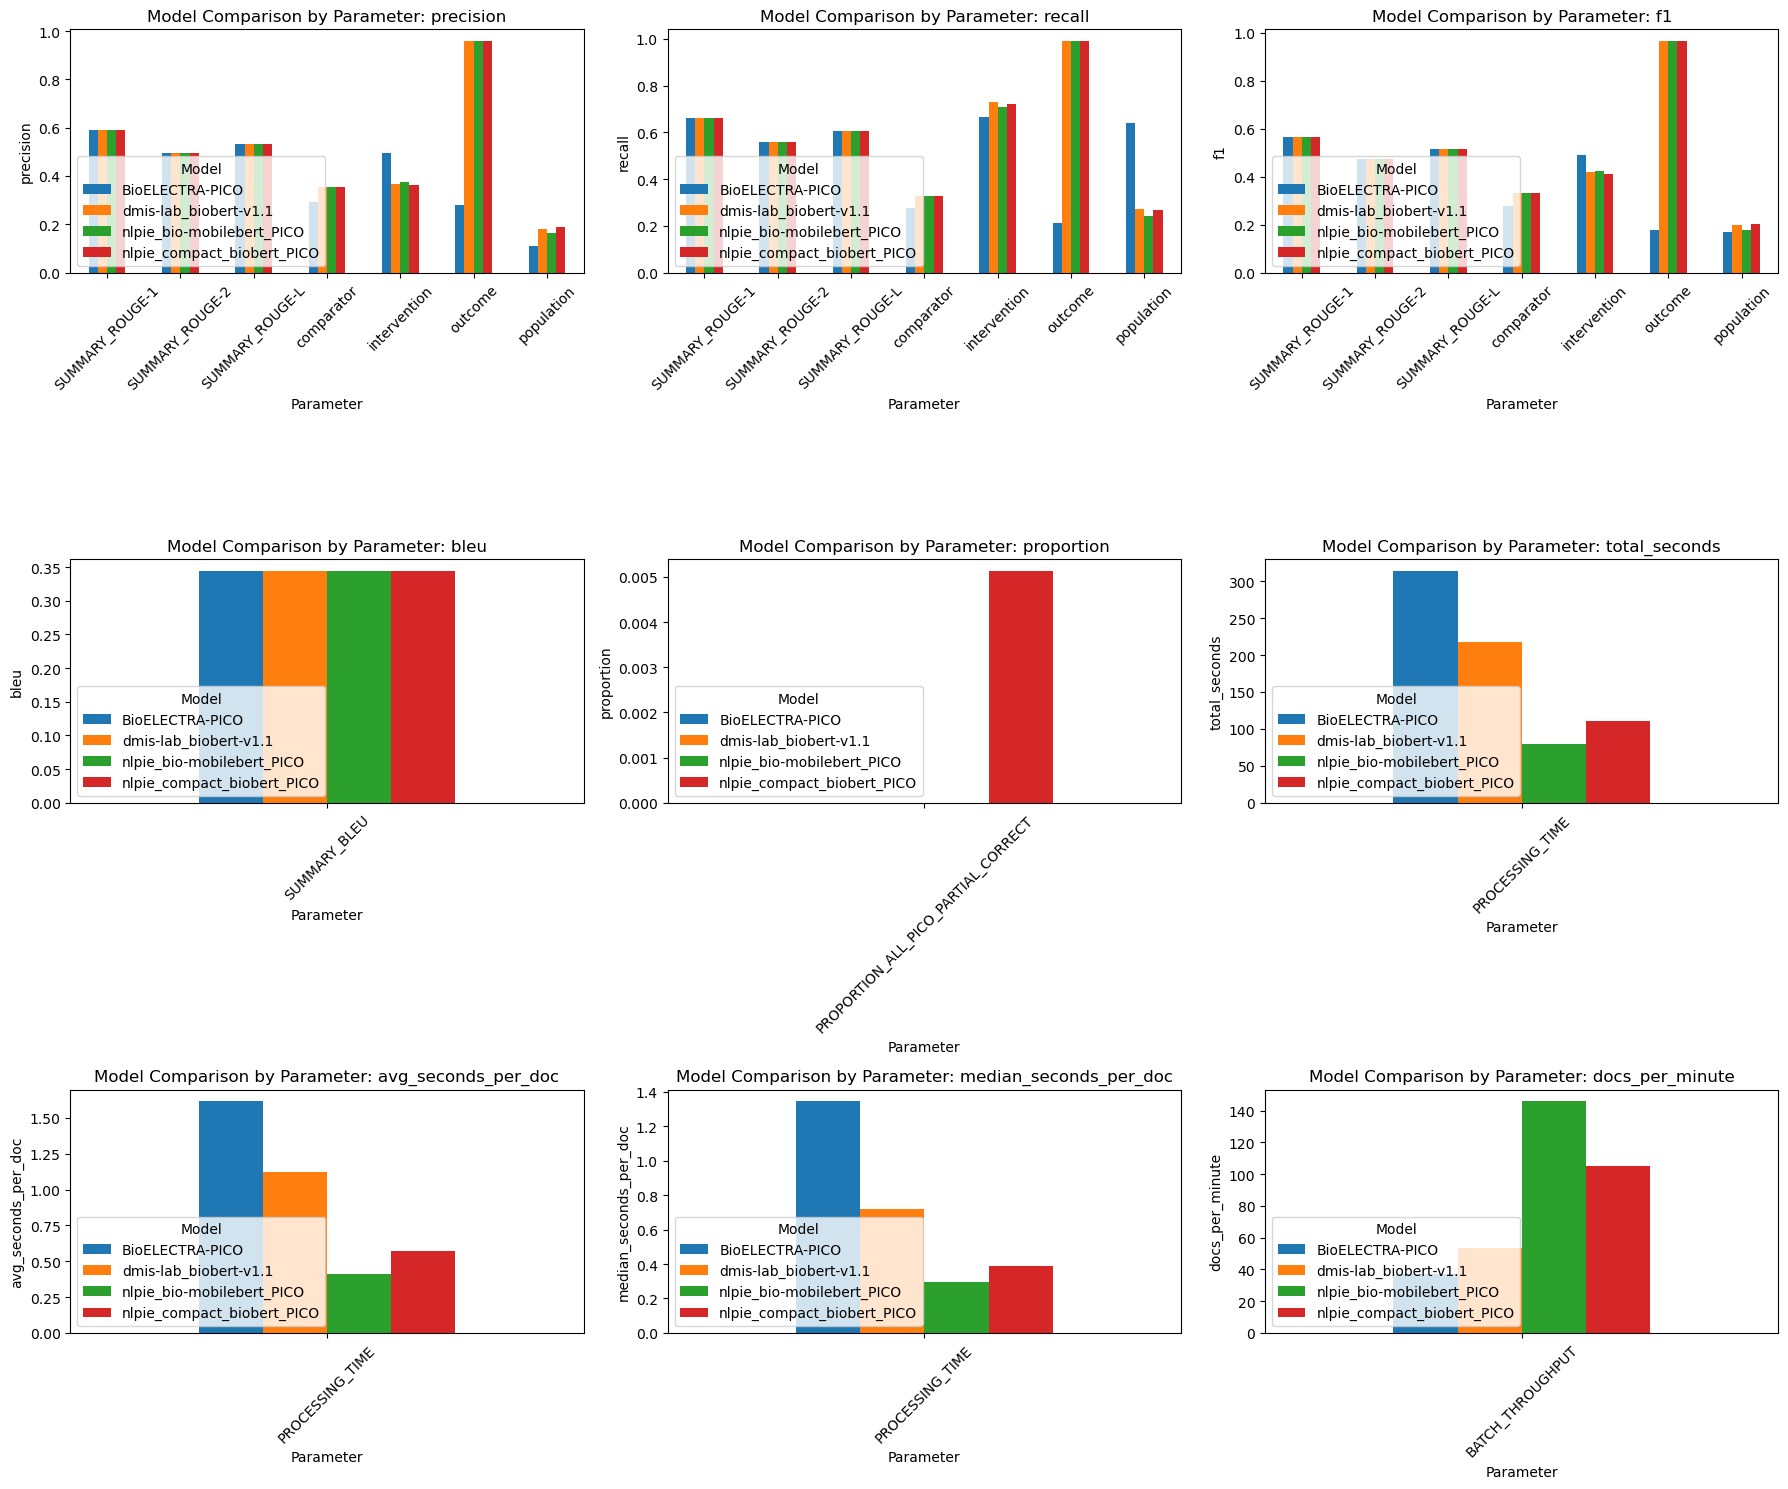

In [9]:
# Rename 'element' to 'parameter' for clarity
df = combined_table.reset_index().rename(columns={'element': 'parameter'})


# List of metric columns to plot
metrics = combined_table.columns[0:9]


# Set up grid layout for subplots
n_cols = 3
n_rows = int(np.ceil(len(metrics) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()


# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    pivot_df = df.pivot(index='parameter', columns='model', values=metric)
    pivot_df = pivot_df.dropna(how='all')  # Remove rows where all model values are NaN
    if not pivot_df.empty:
        pivot_df.plot(kind='bar', ax=ax)
        ax.set_title(f'Model Comparison by Parameter: {metric}')
        ax.set_xlabel('Parameter')
        ax.set_ylabel(metric)
        ax.legend(title='Model', loc='lower left')
        ax.tick_params(axis='x', rotation=45)
        #ax.set_facecolor('white')
    else:
        ax.set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [11]:
combined_table.to_csv("all model results on supergoldgold.txt", sep='\t', decimal=',')